# Example 8 - Stub tuber of the microwave cavity
In this example, we will demonstrate how Bayesian Optimization to assist the design of the microwave (MW) cavity. Microwave technology is known to provide energy efficient, rapid, and selective heating, which is powerful for electrification and intensification of the chemical production process. We would like to find an optimal configuration of the cavity that provides highest power dissipation into the materials.

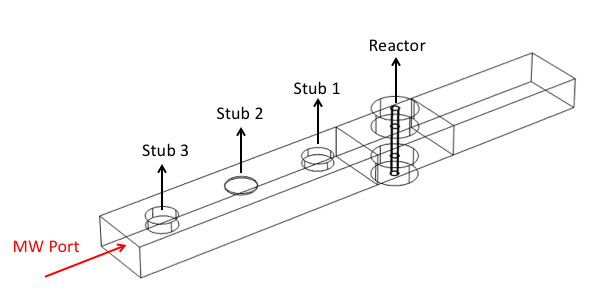

For design, the length of three stubs (X1, X2, and X3) will greatly affect the electromagnetic field in the cavity and the energy diissipated into the materials. They are selected as tunable parameters and define a 3D optimization problem. In this regard, the power dissipated into the materials is the response Y.

There is no analytical objective function available in this example. The reponses are measured from the COMSOL simulations given the designed geometry. When there is a function that we cannot access but we can only observe its outputs based on some given inputs, it is called a black-box function. We call the process of optimizing these input parameters as black box optimization.

The details of this example is summarized in the table below:

| Key Item | Description |
| :- | :- |
| Goal | Maximization |
| Objective function | COMSOL simulation |
| Input (X) dimension	| 3 |
| Output (Y) dimension | 1 |
| Analytical form available?	| No |
| Acqucision function | Expected improvement (EI) |

Next, we will go through each step in Bayesian Optimization.

## 1. Import nextorch and other packages

In [1]:
import os
import sys
import time
import numpy as np
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_path)

from nextorch import bo, io, plotting

/home/tychen/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## 2. Define the design space
We set the names and units for input parameters and output reponses. Their possible operating ranges are also defined.

In [2]:
# Three input final temperature, heating rate, hold time
X_names = ["L_stub1", "L_stub2", "L_stub3"]
X_units = ["mm", "mm", "mm"]

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_names):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)

# One output
Y_name_with_unit = 'Absorbed Power (W)'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the operating range for each parameter
X_ranges = [[1.0, 25.0], [1.0, 25.0], [1.0, 25.0]] # length ranges from 1 to 25 mm

# Set the reponse range
Y_plot_range = [0, 100]

# Get the information of the design space
n_dim = len(X_names) # the dimension of inputs
n_objective = 1 # the dimension of outputs
n_trials = 30 # number of experiment iterations

## 3. Define the initial sampling plan
We don't have an objective function in this example. All the data are collected from simulations. Here we assume we already complete 3 Bayesian Optimization iterations.


In [3]:
X_real = np.array([[1.0, 1.0, 1.0], [5.0, 5.0, 5.0], [25.0, 25.0, 25.0]])
Y_real = np.array([[40.670, 41.717, 6.897]]).T

## 4. Initialize an `COMSOLExperiment` object
In this module, we initialize a `COMSOLExperiment` object to conduct the optimization using the data from the COMSOL simulation. The simulation will automatically be carried out, and the results will be automatically fetched.

In [4]:
#%% Initialize an experimental object 
# Set its name, the files will be saved under the folder with the same name
exp_comsol = bo.COMSOLExperiment("Stub_tuner")
# Import the initial data
exp_comsol.input_data(X_real, 
                      Y_real, 
                      X_names=X_names, 
                      X_units=X_units, 
                      X_ranges=X_ranges,
                      unit_flag = False,
                      decimals=2) #input X and Y in real scales

# Set the optimization specifications 
file_name = "../Stub_tuner/comsol_example" # name of objective COMSOL simulation file
comsol_location =  "/home/tychen/comsol54/multiphysics/bin/comsol" # location of the COMSOL program installed
output_file = "../Stub_tuner/simulation_result.csv" # location of the COMSOL simulation output file
# here we set the objective function, minimization by default
exp_comsol.set_optim_specs(file_name, comsol_location, output_file, comsol_output_col=2, maximize=True)

Iter 10/100: 3.7004592418670654
Iter 20/100: 3.4255552291870117
Iter 30/100: 3.361482620239258
Iter 40/100: 3.340041160583496
Iter 50/100: 3.3286988735198975


## 5. Run trials
We perform 30 more Bayesian Optimization trials using the default acquisition function (Expected Improvement (EI)).

In [5]:
%%capture results 
# Output messages are too long, so they are saved into a variable.
exp_comsol.run_trials_auto(n_trials=n_trials)

## 6. Visualize the final model reponses
Here, we can use `plotting.response_scatter_exp` function to visualize the sampling points and the responses.

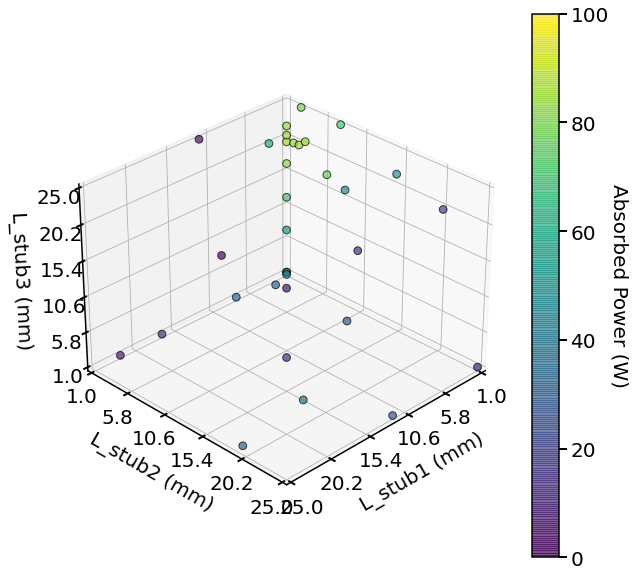

In [6]:
plotting.response_scatter_exp(exp_comsol, Y_plot_range, Y_name_with_unit, 
                              X_ranges=X_ranges, X_names=X_name_with_unit)

## 7. Export the optimum
Obtain the optimum from all sampling points.

The optimal data points is:


,L_stub1 (mm),L_stub2 (mm),L_stub3 (mm),Absorbed Power (W)
0,1.0,1.0,19.46,85.812292


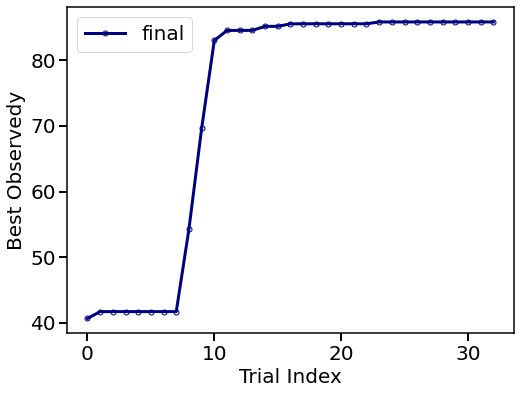

In [7]:
# Plot the optimum discovered in each trial
plotting.opt_per_trial_exp(exp_comsol)
# Extract optimum
y_opt, X_opt, index_opt = exp_comsol.get_optim()
data_opt = io.np_to_dataframe([X_opt, y_opt], var_names)
print('The optimal data points is:'.format(i))
display(data_opt)